In [1]:
import os
import sys
import time
import copy
import math
import torch
import argparse
import tracemalloc
import numpy as np
import torch.nn as nn
import torch.linalg as LA
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.optimizer import Optimizer, required

In [2]:
def prox(x, c):
    # soft thresholding operator that returns argmin(|x-y|^2 + 2c|y|_1)
    return F.softshrink(x, lambd=c)

def get_loss(x, data, labels):
    return nn.MSELoss()(data @ x, labels).item()

def get_grad_mappin(x, data, labels, gamma, c):
    xb = data @ x
    ratio = 2 * (xb - labels)
    V = ratio[:, :, None] * data
    grad = torch.mean(V, dim=(0,1))
    if c != 0:
        y = prox(x - gamma * grad, c)
        gm = torch.linalg.norm(y-x)/gamma
    else:
        gm = torch.linalg.norm(grad)

    return gm.item()

def streaming_data(beta, num_of_nodes, dimension, batch_size, noise_rate):
    data = torch.zeros(num_of_nodes, batch_size, dimension)
    labels = torch.zeros(num_of_nodes, batch_size)
    for i in range(num_of_nodes):
        data[i] = torch.normal(mean=0, std=1, size=(batch_size, dimension))
        labels[i] = data[i] @ beta + noise_rate * torch.normal(mean=0, std=1, size=(batch_size,))
    return data, labels

def comm_mat(network_topology, multi_round, n):
    net_type, param = network_topology
    W = torch.eye(n)
    if net_type == 'ring':
        for i in range(1, n-1):
            a, b = param, 0.5 * (1 - param)
            W[i, i], W[i, i+1], W[i, i-1] = a, b, b
        W[0, 0], W[0, 1], W[0, n-1] = a, b, b
        W[n-1, 0], W[n-1, n-2], W[n-1][n-1] = b, b, a
    elif net_type == 'complete':
        W = torch.full((n, n), (1-param)/(n-1))
        for i in range(n):
            W[i, i] = param
    else:
        raise NotImplementedError
    return LA.matrix_power(W, multi_round)

In [3]:
# random seed
seed = 1

# problem parameters
dimension, num_of_nodes = 100, 8
noise_rate = 0.2
network_topology = ['ring', 0.4]
# network_topology = ['complete', 1 / num_of_nodes]

sparsity_ratio, test_ratio = 0.3, 0.2
sparsity_num = int(dimension * sparsity_ratio)
beta = torch.zeros(dimension)
indices = torch.randperm(dimension)[0: sparsity_num]
beta[indices] = torch.normal(mean=0, std=1, size=(sparsity_num, ))

# test set
data_test, labels_test = streaming_data(beta, num_of_nodes, dimension, 10000, noise_rate)
# torch.normal(mean=0, std=1, size=(100000, dimension))
# labels_test = g(data_test @ beta) + noise_rate * torch.normal(mean=0, std=1, size=(100000,))

In [4]:
# linear speedup experiments for online setting
node_num_list = [5,10,20]
loss_list = []
gm_list = []

x_init = torch.randn(size=(1,))

# problem parameters
dimension = 100
noise_rate = 0.1
network_topology = ['ring', 0.4]
# network_topology = ['complete', 1 / num_of_nodes]

c = 0
sparsity_ratio = 0.3
sparsity_num = int(dimension * sparsity_ratio)
beta = torch.zeros(dimension)
indices = torch.randperm(dimension)[0: sparsity_num]
beta[indices] = torch.normal(mean=0, std=1, size=(sparsity_num, ))

for num_of_nodes in node_num_list:
    # test set
    data_test, labels_test = streaming_data(beta, num_of_nodes, dimension, 10000, noise_rate)

    a, K = 0, 10000
    batch_size = 1 
    # alpha, lam, gamma = math.sqrt(num_of_nodes/K), a, 0.001
    lam, alpha, gamma = 0, math.sqrt(num_of_nodes/K), num_of_nodes**(1/4) / K**(3/4)
    # noise_rate = 0.1
        
    # initialization
    X, Z = torch.ones(size=(num_of_nodes, dimension)) * x_init, \
            torch.zeros(size=(num_of_nodes, dimension))
    X_history = torch.zeros(K+1, dimension)
    X_history[0] = torch.mean(X, dim=0)
    loss_history = torch.zeros(K+1)
    loss_history[0] = get_loss(X_history[0], data_test, labels_test)  + lam * torch.linalg.norm(X_history[0], ord=1)
    gm_history = torch.zeros(K+1)
    gm_history[0] = get_grad_mappin(X_history[0], data_test, labels_test, gamma, c)

    W1 = comm_mat(network_topology, 1, num_of_nodes)
    rho = torch.topk(torch.linalg.eigvalsh(W1), 2).values[1]
    multi_round = int(np.log(num_of_nodes)/(1-rho))
    Wm = comm_mat(network_topology, multi_round, num_of_nodes)

    for k in range(K):
        # local update
        for i in range(num_of_nodes):
            temp = torch.linalg.norm(Z[i])
            if temp != 0:
                X[i] = X[i] - gamma * Z[i] / temp

        # online setting
        data, labels = streaming_data(beta, num_of_nodes, dimension, batch_size=batch_size, noise_rate=noise_rate)

        temp = torch.bmm(data, X.reshape(num_of_nodes, dimension, 1))
        V = 2 * (temp - labels.reshape(num_of_nodes, batch_size, 1)) * data
        V = torch.mean(V, dim=1)
        Z.add_(V - Z, alpha=alpha)
        #communication

        # X, Z = Wm @ X , Wm @ Z
        X, Z = W1 @ X , W1 @ Z
        X_history[k+1] = torch.mean(X, dim=0)
        loss_history[k+1] = get_loss(X_history[k+1], data_test, labels_test) # + lam * torch.linalg.norm(X_history[k+1], ord=1)
        gm_history[k+1] = get_grad_mappin(X_history[k+1], data_test, labels_test, gamma, c)
        
    loss_list.append(loss_history)
    gm_list.append(gm_history)

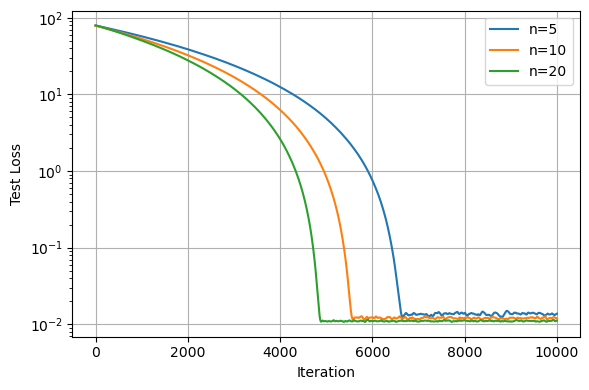

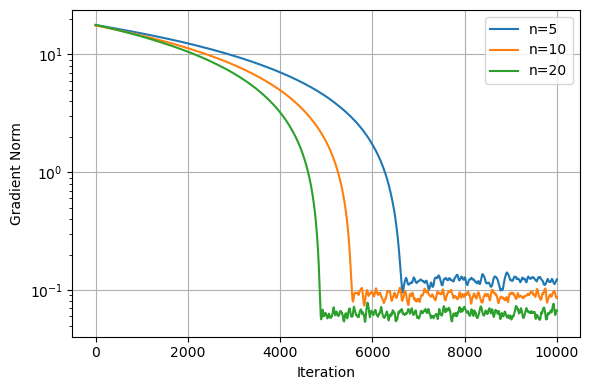

In [5]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
plt.xlabel('Iteration')
ax.set_ylabel('Test Loss')
ax.set_yscale('log')
for i, loss in enumerate(loss_list):
    plt.plot(loss, label='n={}'.format(node_num_list[i]))
plt.legend()
plt.grid()
plt.savefig("plots/linear_speedup_loss_constant.pdf")
plt.show()


fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
plt.xlabel('Iteration')
ax.set_ylabel('Gradient Norm')
ax.set_yscale('log')
for i, gm in enumerate(gm_list):
    plt.plot(gm, label='n={}'.format(node_num_list[i]))
plt.legend()
plt.grid()
plt.savefig("plots/linear_speedup_norm_constant.pdf")
plt.show()

In [6]:
# linear speedup experiments for online setting
node_num_list = [5,10,20]
loss_list = []
gm_list = []

x_init = torch.randn(size=(1,))

# problem parameters
dimension = 100
noise_rate = 0.1
network_topology = ['ring', 0.4]
# network_topology = ['complete', 1 / num_of_nodes]

c = 0
sparsity_ratio = 0.3
sparsity_num = int(dimension * sparsity_ratio)
beta = torch.zeros(dimension)
indices = torch.randperm(dimension)[0: sparsity_num]
beta[indices] = torch.normal(mean=0, std=1, size=(sparsity_num, ))

for num_of_nodes in node_num_list:
    # test set
    data_test, labels_test = streaming_data(beta, num_of_nodes, dimension, 10000, noise_rate)

    a, K = 0, 10000
    batch_size = 1
    lam = 0
    # noise_rate = 0.1
        
    # initialization
    X, Z = torch.ones(size=(num_of_nodes, dimension)) * x_init, \
            torch.zeros(size=(num_of_nodes, dimension))
    X_history = torch.zeros(K+1, dimension)
    X_history[0] = torch.mean(X, dim=0)
    loss_history = torch.zeros(K+1)
    loss_history[0] = get_loss(X_history[0], data_test, labels_test)  + lam * torch.linalg.norm(X_history[0], ord=1)
    gm_history = torch.zeros(K+1)
    gm_history[0] = get_grad_mappin(X_history[0], data_test, labels_test, gamma, c)

    W1 = comm_mat(network_topology, 1, num_of_nodes)
    rho = torch.topk(torch.linalg.eigvalsh(W1), 2).values[1]
    multi_round = int(np.log(num_of_nodes)/(1-rho))
    Wm = comm_mat(network_topology, multi_round, num_of_nodes)

    for k in range(K):
        alpha, gamma = math.sqrt(num_of_nodes / (k + 1)), (num_of_nodes) ** (0.25) / ((k+1) ** (0.75))

        # local update
        for i in range(num_of_nodes):
            temp = torch.linalg.norm(Z[i])
            if temp != 0:
                X[i] = X[i] - gamma * Z[i] / temp

        # online setting
        data, labels = streaming_data(beta, num_of_nodes, dimension, batch_size=batch_size, noise_rate=noise_rate)

        temp = torch.bmm(data, X.reshape(num_of_nodes, dimension, 1))
        V = 2 * (temp - labels.reshape(num_of_nodes, batch_size, 1)) * data
        V = torch.mean(V, dim=1)
        Z.add_(V - Z, alpha=alpha)
        #communication

        # X, Z = Wm @ X , Wm @ Z
        X, Z = W1 @ X , W1 @ Z
        X_history[k+1] = torch.mean(X, dim=0)
        loss_history[k+1] = get_loss(X_history[k+1], data_test, labels_test) # + lam * torch.linalg.norm(X_history[k+1], ord=1)
        gm_history[k+1] = get_grad_mappin(X_history[k+1], data_test, labels_test, gamma, c)
        
    loss_list.append(loss_history)
    gm_list.append(gm_history)

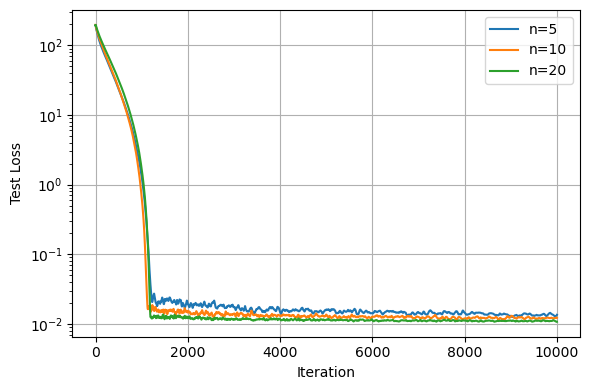

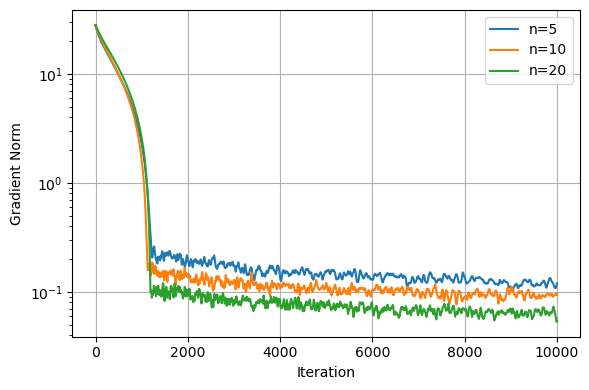

In [7]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
plt.xlabel('Iteration')
ax.set_ylabel('Test Loss')
ax.set_yscale('log')
for i, loss in enumerate(loss_list):
    plt.plot(loss, label='n={}'.format(node_num_list[i]))
plt.legend()
plt.grid()
plt.savefig("plots/linear_speedup_loss_diminishing.pdf")
plt.show()


fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
plt.xlabel('Iteration')
ax.set_ylabel('Gradient Norm')
ax.set_yscale('log')
for i, gm in enumerate(gm_list):
    plt.plot(gm, label='n={}'.format(node_num_list[i]))
plt.legend()
plt.grid()
plt.savefig("plots/linear_speedup_norm_diminishing.pdf")
plt.show()